# Определение возраста покупателей

## Исследовательский анализ данных

### Импортирование и установка библиотек

In [10]:
#Импортируем необходимые библиотеки:

#Библиотеки для работы с табличными данными:
import pandas as pd
import numpy as np

#Библиотеки визуализации:
import matplotlib.pyplot as plt
import seaborn as sns

#Системный модуль:
import os

#Библиотеки для работы с изображениями:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

### Выгрузка и просмотр данных

#### Табличные данные

In [11]:
#Локальный путь к файлу:
local_path = '/datasets/faces/labels.csv'

#Проверяем наличие файла по заданному локальному пути:
if os.path.exists(local_path):
    
    #Считываем файл
    df = pd.read_csv(local_path)
    print("Данные загружены из локального файла")
    
    # Узнаем размер файла в байтах
    file_size = os.path.getsize(local_path)
    print(f"Размер файла: {file_size / (1024 * 1024):.2f} MB") 

#Генерируем исключение:   
else:
    print("Данных о файле нет в локальной директории")
    
#Используем специальную команду отображения таблиц, для наглядного просмотра всех данных:    
#pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Данные загружены из локального файла
Размер файла: 0.11 MB


In [12]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [14]:
df.duplicated().sum()

0

> Размер `csv` файла - `0.11 MB` (выгружен с локальной директории)

> Таблица состоит из `2 столбцов` (название файла и соответвующий возраст) и `7591 наблюдения` 

> Пропусков и дубликатов - **нет**

Построим гистограмму распределения возраста:

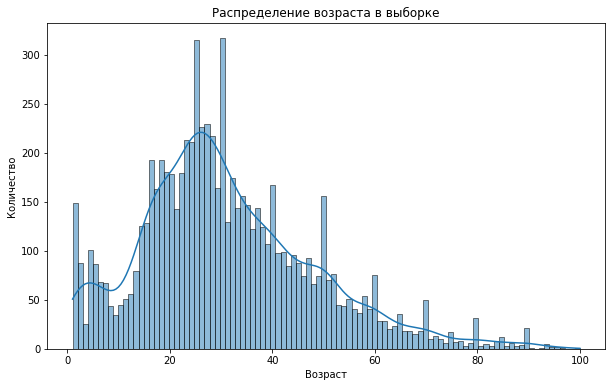

Мода распределения возраста: 30
Минимальный возраст: 1
Максимальный возраст: 100


In [15]:
# Гистограмма распределения возраста
plt.figure(figsize=(10, 6))
sns.histplot(df['real_age'], bins=100, kde=True)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()
print(f"Мода распределения возраста: {df['real_age'].mode()[0]}")
print(f"Минимальный возраст: {df['real_age'].min()}")
print(f"Максимальный возраст: {df['real_age'].max()}")

> Из гистограммы видно, что **распределение схоже с нормальным**

> Самое часто встречающееся значение - 30 лет

> Данные лежат в допустимом диапозоне

#### Выгрузка изображений

Found 7591 validated image filenames.


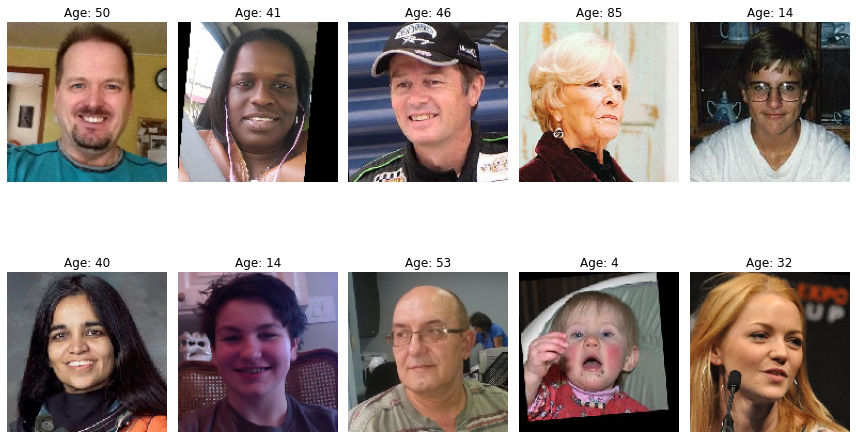

In [7]:
#Укажем путь к папке с изображениями
image_dir = '/datasets/faces/final_files/'

#Создадим генератор изображений
datagen = ImageDataGenerator(rescale=1./255)

data_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),  
    batch_size=16,
    class_mode='raw',
    shuffle=True,
    seed=12345
)

#Загрузим изображения:
images, labels = next(data_generator)

#Отобразим изображения:
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Age: {int(labels[i])}")
    plt.axis('off')

#Задаем расстояние:
plt.tight_layout()
plt.show()

> Изображения в цветовой политре `RGB` и одноканальные (серый оттенок)

> Возраст на изображения соответсвует данным из ***df***

> Изображения имеют достаточно хорошее качество

> Данные для обучения сбалансированы

### Вывод по EDA

В ходе исследования и анализа изображений были получены следующие результаты:

**1. Возрастные характеристики:**

- Мода (наиболее часто встречающийся возраст) среди изображений составляет 30 лет.

- Возрастной диапазон представленных данных варьируется от 1 до 100 лет, что свидетельствует о широком охвате возрастных групп в выборке.

**2. Качество и характеристики изображений:**

- Изображения представлены как в цветовой палитре **`RGB`**, так и в одноканальном режиме (серый оттенок), что позволяет провести дальнейший анализ с учётом цветовой информации.

- Качество изображений соответствует необходимым стандартам, что гарантирует точность и надёжность последующего анализа.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        rescale=1/255.,
        validation_split=0.25,
#         vertical_flip=True,
        horizontal_flip=True
    )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen_flow
    
    
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        rescale=1/255.,
        validation_split=0.25
    )
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_datagen_flow

    
def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(learning_rate=0.0005)
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    
    return model
    
    
def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=10,
    steps_per_epoch=None,
    validation_steps=None
):
    model.fit( 
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        shuffle=True,
        verbose=2
    )
    
    return model

```

---

```

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 3s
  229376/94765736 [..............................] - ETA: 21s
 1097728/94765736 [..............................] - ETA: 8s
 4923392/94765736 [>.............................] - ETA: 2s
11370496/94765736 [==>...........................] - ETA: 1s
18374656/94765736 [====>.........................] - ETA: 1s
25378816/94765736 [=======>......................] - ETA: 0s
32792576/94765736 [=========>....................] - ETA: 0s
39952384/94765736 [===========>..................] - ETA: 0s
46514176/94765736 [=============>................] - ETA: 0s
53534720/94765736 [===============>..............] - ETA: 0s
60784640/94765736 [==================>...........] - ETA: 0s
67584000/94765736 [====================>.........] - ETA: 0s
74498048/94765736 [======================>.......] - ETA: 0s
81248256/94765736 [========================>.....] - ETA: 0s
87990272/94765736 [==========================>...] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2024-08-15 12:30:33.946076: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-08-15 12:30:35.231792: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 76s - loss: 195.6857 - mae: 10.4353 - val_loss: 304.8897 - val_mae: 12.9564
Epoch 2/10
178/178 - 43s - loss: 106.2800 - mae: 7.8353 - val_loss: 350.8601 - val_mae: 13.9260
Epoch 3/10
178/178 - 43s - loss: 71.9261 - mae: 6.4750 - val_loss: 285.9780 - val_mae: 12.7445
Epoch 4/10
178/178 - 43s - loss: 46.9975 - mae: 5.3070 - val_loss: 202.0062 - val_mae: 11.0086
Epoch 5/10
178/178 - 43s - loss: 32.7978 - mae: 4.4253 - val_loss: 104.7139 - val_mae: 7.7221
Epoch 6/10
178/178 - 44s - loss: 23.9518 - mae: 3.7910 - val_loss: 80.3460 - val_mae: 6.9281
Epoch 7/10
178/178 - 46s - loss: 17.2735 - mae: 3.2022 - val_loss: 84.9072 - val_mae: 7.2432
Epoch 8/10
178/178 - 46s - loss: 13.2600 - mae: 2.8124 - val_loss: 107.6054 - val_mae: 7.5992
Epoch 9/10
178/178 - 46s - loss: 10.8628 - mae: 2.5303 - val_loss: 88.8418 - val_mae: 7.3197
Epoch 10/10
178/178 - 46s - loss: 10.0438 - mae: 2.4005 - val_loss: 72.6493 - val_mae: 6.5372
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 72.6493 - mae: 6.5372
Test MAE: 6.5372

```

## Анализ обученной модели

**Использованная архитектура:**

В качестве основы модели (бэкбона) был использован **`ResNet50`**, предобученный на наборе данных **ImageNet**. Модель была модифицирована путём добавления головы, состоящей из слоя глобального среднего объединения **`GlobalAveragePooling2D`** и плотного слоя **`Dense`** с одной выходной нейронной сетью и функцией активации **`ReLU`** для предсказания возраста.

Веса модели были загружены из предобученной версии, что позволило использовать уже обученные на **ImageNet** представления для задачи классификации возрастов.

---

**Параметры обучения:**

- В процессе обучения был использован оптимизатор **`Adam`** с начальной скоростью обучения 0.0005.

- Размер батча составлял **`32`** изображения, а обучение проводилось в течение **`10 эпох`**.

- Заморозка весов бэкбона не использовалась, что позволило всей модели обучаться на новых данных с нуля.

---

**Анализ метрик:**

> ***loss***: На первых эпохах потери были высоки, но они постепенно снижались, что говорит о том, что модель обучается. В последние эпохи потери на обучающем наборе продолжали снижаться

> ***MAE***: Начальные значения метрики довольно высоки, но постепенно снижаются, что также указывает на улучшение качества модели

> ***val loss***: Значения потерь на валидационном наборе данных изначально уменьшались, но к 7 эпохе стали увеличиваться. Это может свидетельствовать о переобучении, модель начинает подстраиваться под обучающие данные, а не обобщаться на новые


---

**Переобучение:**

Признаки переобучения действительно наблюдаются после 7-й эпохи, когда валидационные потери начали расти, несмотря на снижение обучающих потерь. Это может говорить о том, что модель начинает "запоминать" обучающие данные, теряя способность к обобщению на новые данные. Для уменьшения эффекта переобучения в дальнейшем можно рассмотреть такие методы, как регулирозация, ранняя остановка или использование большего количества данных.

## Вывод

Средняя абсолютная ошибка **`MAE`** со значением **`6.5372`** говорит о том, что в среднем наша модель ошибается на 6.5 лет при прогнозировании возраста на основе изображений

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы